In [30]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, optimization_visualization_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(optimization_visualization_helper)

from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint, get_max_distance_to_target_surface, get_average_distance_to_target_joint)

from optimization_visualization_helper import (compute_visualization_data_from_raw_data, get_objective_components_stage1, get_objective_components_stage2, set_figure_label_and_limit, Visualization_Setting, set_figure_label_and_limit)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('chicago_bean_1', thickness, width, weaving_dir)

0.033273539253433904 0.0023291477477403733


In [4]:
import benchmark
benchmark.reset()

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=False)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [6]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 0.01
sw = 0.01

In [7]:
# iterateData = stage_1_optimization(curved_linkage, rw, sw, curved_linkage_view)

In [10]:
# import linkage_optimization

In [11]:
# optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view)

In [12]:
# optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

In [14]:
iterateData = np.load('stage_1_iteration_data.npy', allow_pickle = True)

In [15]:
opt_iterateData = np.load('stage_2_iteration_data.npy', allow_pickle = True)

In [16]:
curved_linkage.setExtendedDoFsPSRL(opt_iterateData[-1][-1])

In [17]:
curved_linkage.attraction_weight = 1e-5

In [18]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [19]:
OPTS.niter = 1000

In [20]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.000944744	0.582849	0.582849	1	1
1	5.82175e-05	0.0282991	0.0282991	1	1
2	3.77036e-05	0.00660504	0.00660504	1	1
3	3.05537e-05	0.00284653	0.00284653	1	1
4	2.56619e-05	0.00136901	0.00136901	1	1
5	2.22603e-05	0.000712969	0.000712969	1	1
6	2.01213e-05	0.000378791	0.000378791	1	1
7	1.89538e-05	0.000219917	0.000219917	1	0
8	1.80306e-05	0.00361276	0.00361276	1	0
9	1.80136e-05	1.88679e-05	1.88679e-05	1	0
10	1.80136e-05	2.09899e-06	2.09899e-06	0.5	0
11	1.80136e-05	2.59156e-06	2.59156e-06	1	0
12	1.80136e-05	9.71094e-08	9.71094e-08	1	0


In [21]:
# save_path = os.getcwd()
# write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
# os.chdir(save_path)

In [22]:
len(opt_iterateData)

175

In [31]:
opt_elastic_energy, opt_smoothing, opt_rest_length, opt_total_absolute_curvature, opt_distance_to_surface, opt_distance_to_joint, opt_time_stamps, opt_eqm_dofs = compute_visualization_data_from_raw_data(opt_iterateData, io)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
267.5483651161194


In [32]:
dps_elastic_energy, dps_smoothing, dps_rest_length, dps_total_absolute_curvature, dps_distance_to_surface, dps_distance_to_joint, dps_time_stamps, dps_eqm_dofs = compute_visualization_data_from_raw_data(iterateData, io)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
1865.2459070682526


In [33]:
dps_objective_elastic, dps_objective_smooth, dps_objective_length, dps_total_objective = get_objective_components_stage1(iterateData)

In [34]:
opt_objective_elastic, opt_objective_target, opt_objective_smooth, opt_objective_length, opt_total_objective = get_objective_components_stage2(opt_iterateData)

### Visualization Settings

In [96]:
cmap = plt.get_cmap("Set2")
elastic_color = '#555358'
target_color = cmap(1)
rest_length_color = cmap(2)
smoothness_color = cmap(3)
curvature_color = cmap(4)

elastic_label = 'Elastic Energy'
target_label = 'Distance to Surface'
rest_length_label = 'Rest Length Sum'
smoothness_label = 'Smoothing Cost'
curvature_label = 'Curvature Sum'
x_label = 'Iteration'
figure_size = (15, 6)
figure_label_size = 30

stage_1_label = 'Stage 1'
stage_2_label = 'Stage 2'

# design_optimization_iteration_range = [x + 0 for x in list(range(len(total_objective)))]



In [5]:
import numpy as np
np.min([1, np.nan])

nan

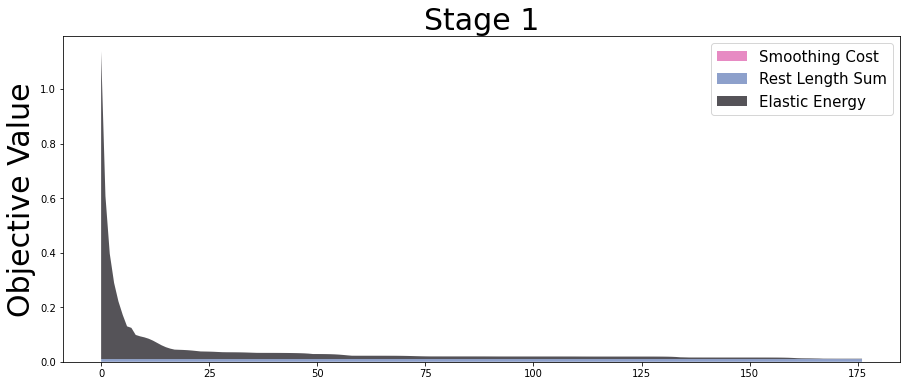

In [63]:
# library
import numpy as np
import matplotlib.pyplot as plt
 
fig, host = plt.subplots()
cmap = plt.get_cmap("Set2")
colors = [smoothness_color, rest_length_color, elastic_color]
x=range(len(dps_objective_elastic))
y=np.array([dps_objective_smooth, dps_objective_length, dps_objective_elastic])
 
# Basic stacked area chart.
plt.stackplot(x,y, labels=[smoothness_label, rest_length_label, elastic_label], colors = colors)
plt.legend(loc='upper right', prop={'size': 15}, fancybox=True)
#plt.show()
# host.set_yscale('log')
fig.set_size_inches(figure_size)
plt.ylabel('Objective Value', fontsize = figure_label_size)
plt.title(stage_1_label, fontsize = figure_label_size)
fig.set_size_inches(figure_size)
# fig.savefig('kleinbottle_nature_figure3_D_top_left.png', bbox_inches='tight', dpi=400)

3.106109495785062 0.8437290750729639


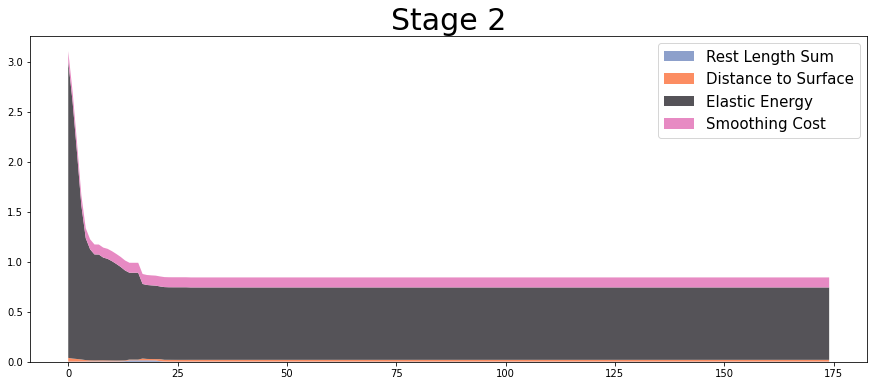

In [65]:
# library
import numpy as np
import matplotlib.pyplot as plt
 
fig, host = plt.subplots()
x=range(len(opt_objective_length))
y=np.array([opt_objective_length, opt_objective_target, opt_objective_elastic, opt_objective_smooth])
colors = [rest_length_color, target_color, elastic_color, smoothness_color]
# Basic stacked area chart.
plt.stackplot(x,y, labels=[rest_length_label, target_label, elastic_label, smoothness_label], colors = colors)
plt.legend(loc='upper right', prop={'size': 15}, fancybox=True)
#plt.show()
# host.set_yscale('exp')
print(max(total_objective), min(total_objective))
plt.title(stage_2_label, fontsize = figure_label_size)
fig.set_size_inches(figure_size)
fig.savefig('kleinbottle_nature_figure3_D_top_left_stacked.png', bbox_inches='tight', dpi=400)

### Figure 3E Top Left

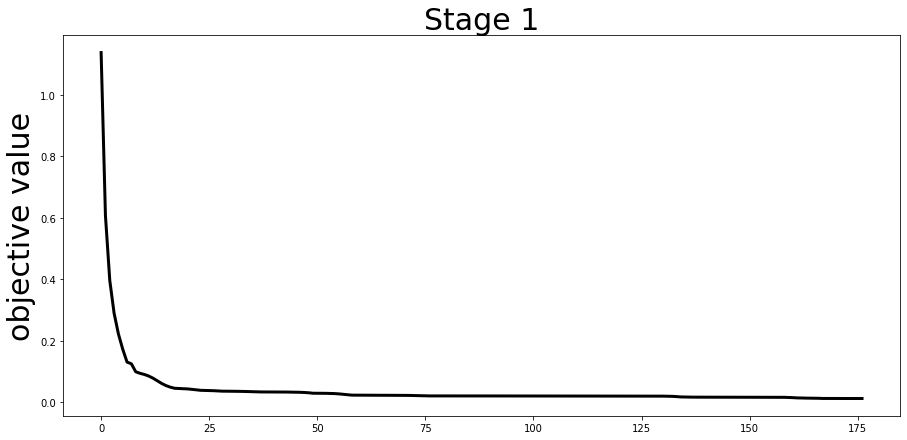

In [66]:
# library
import numpy as np
import matplotlib.pyplot as plt

fig, host = plt.subplots()
cmap = plt.get_cmap("Set2")
colors = [cmap(3), cmap(2), cmap(1)]
x=range(len(dps_objective_elastic))
y=dps_total_objective
 
# Basic stacked area chart.
plt.plot(x,y, label = 'Objective', color = 'k', linewidth = 3)
#plt.show()
# host.set_yscale('log')
# plt.xlabel('iteration', fontsize = figure_label_size)
plt.ylabel('objective value', fontsize = figure_label_size)
plt.title(stage_1_label, fontsize = figure_label_size)
fig.set_size_inches((15, 7))
fig.savefig('kleinbottle_nature_figure3_D_top_left.png', bbox_inches='tight', dpi=400)

### Figure 3E Top Right

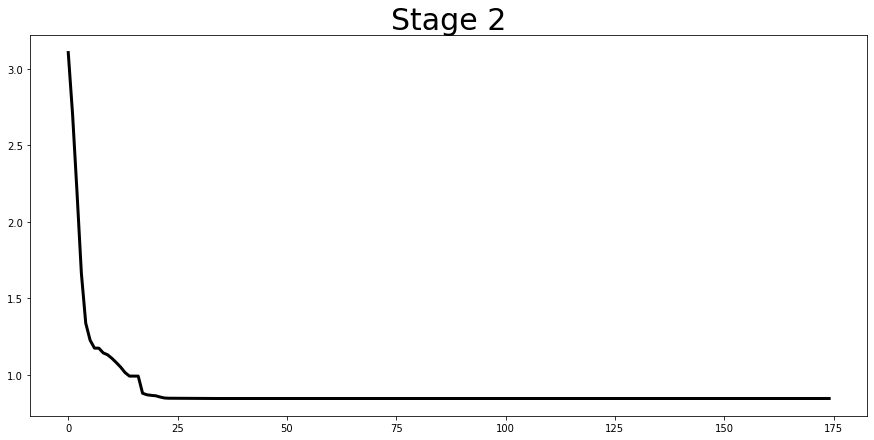

In [67]:
# library
import numpy as np
import matplotlib.pyplot as plt
 
fig, host = plt.subplots()
cmap = plt.get_cmap("Set2")
colors = [cmap(3), cmap(2), cmap(1)]
x=[-1] + list(range(len(total_objective)))
y=[np.nan] + list(total_objective)
 
# Basic stacked area chart.
plt.plot(x,y, label = 'Objective', color = 'k', linewidth = 3)
#plt.show()
# host.set_yscale('log')
# plt.xlabel(x_label, fontsize = figure_label_size)
# plt.ylabel('objective value', fontsize = figure_label_size)
plt.title(stage_2_label, fontsize = figure_label_size)

fig.set_size_inches((15, 7))
fig.savefig('kleinbottle_nature_figure3_D_top_right.png', bbox_inches='tight', dpi=400)

In [69]:
combined_energy = (np.array(dps_elastic_energy + opt_elastic_energy))
combined_rest_length = np.array(dps_rest_length + opt_rest_length)
combined_smoothing = np.array(dps_smoothing + opt_smoothing)
combined_total_absolute_curvature = np.array(dps_total_absolute_curvature + opt_total_absolute_curvature)
combined_distance_to_surface = np.array(dps_distance_to_surface + opt_distance_to_surface)
combined_dis_to_target_joint = np.array(dps_distance_to_joint + opt_distance_to_joint)
combined_time_stamps = np.array(dps_time_stamps + opt_time_stamps)

In [70]:
sum(dps_time_stamps)

26.381705284118652

In [71]:
sum(opt_time_stamps[:])

58.54908726286821

#### Load data

In [17]:
# # load data
# combined_energy = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format("energy"))
# combined_rest_length = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format("rest_length"))
# combined_smoothing = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format("smoothness"))
# combined_total_absolute_curvature = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format("curvature"))
# combined_distance_to_surface = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('dis_surface'))
# combined_time_stamps = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('time_stamps'))

# dps_eqm_dofs = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('dps_eqm_dofs'))
# opt_eqm_dofs = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('opt_eqm_dofs'))

# dps_total_objective = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('dps_total_objective'))
# total_objective = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('opt_total_objective'))

# opt_objective_elastic = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('opt_objective_elastic'))
# opt_objective_target = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('opt_objective_target'))
# opt_objective_smooth = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('opt_objective_smooth'))
# opt_objective_length = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('opt_objective_length'))
# dps_objective_elastic = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('dps_objective_elastic'))
# dps_objective_smooth = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('dps_objective_smooth'))
# dps_objective_length = np.load("kleinbottle_nature_figure3/nature_figure3_plot_data/{}.npy".format('dps_objective_length'))

# dps_iteration_count = len(dps_total_objective)

# dps_energy = combined_energy[:dps_iteration_count]
# dps_rest_length = combined_rest_length[:dps_iteration_count]
# dps_smoothing = combined_smoothing[:dps_iteration_count]
# dps_total_absolute_curvature = combined_total_absolute_curvature[:dps_iteration_count]
# dps_distance_to_surface = combined_distance_to_surface[:dps_iteration_count]
# dps_time_stamps = combined_time_stamps[:dps_iteration_count]

# opt_energy = combined_energy[dps_iteration_count:]
# opt_rest_length = combined_rest_length[dps_iteration_count:]
# opt_smoothing = combined_smoothing[dps_iteration_count:]
# opt_total_absolute_curvature = combined_total_absolute_curvature[dps_iteration_count:]
# opt_distance_to_surface = combined_distance_to_surface[dps_iteration_count:]
# opt_time_stamps = combined_time_stamps[dps_iteration_count:]



In [23]:
dps_distance_to_surface[0] / 2

0.029238932745848416

In [19]:
print(combined_energy[117], combined_rest_length[117], combined_total_absolute_curvature[117])

0.00018928042045572834 79.80008216496539 0.00027657614729339537


In [20]:
print(combined_energy[118], combined_rest_length[118], combined_total_absolute_curvature[118])

0.0001890904347162177 79.80011154715918 0.00027964056544413986


In [21]:
print(combined_energy[119], combined_rest_length[119], combined_total_absolute_curvature[119])

0.0001883477553259902 79.80022908997755 0.00029186936163265405


In [22]:
dps_iteration_count = len(dps_total_objective)

In [23]:
print(dps_iteration_count)

997


In [24]:
dps_distance_to_surface[0]

0.05847786549169683

In [80]:
min(opt_distance_to_surface)

0.004969440944504727

In [81]:
min(dps_distance_to_surface)

0.008916921444955138

In [26]:
(dps_distance_to_surface[-1])

0.013503044767674246

### Figure 3E Bottom Left

In [72]:
def set_figure_label_and_limit(host, par1, par2, par3, par4, p1, p2, p3, p4, p5):
    host.set_ylim(min(combined_energy)* 0.8, max(combined_energy)* 1.1)
    par1.set_ylim(min(combined_rest_length)* 0.99, max(combined_rest_length)* 1.01)
    par2.set_ylim(min(combined_smoothing)* 0.8, max(combined_smoothing)* 1.1)
    par3.set_ylim(min(combined_total_absolute_curvature)* 0.8, max(combined_total_absolute_curvature)* 1.01)
    par4.set_ylim(min(combined_distance_to_surface)* 0.8, max(combined_distance_to_surface)* 1.01)

    host.set_yscale('log')

    host.set_xlabel(x_label, fontsize = figure_label_size)
    host.set_ylabel(elastic_label, fontsize = figure_label_size)
    par1.set_ylabel(rest_length_label, fontsize = figure_label_size)
    par2.set_ylabel(smoothness_label, fontsize = figure_label_size)
    par3.set_ylabel(curvature_label, fontsize = figure_label_size)
    par4.set_ylabel(target_label, fontsize = figure_label_size)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    par3.yaxis.label.set_color(p4.get_color())
    par4.yaxis.label.set_color(p5.get_color())

    host.yaxis.label.set_fontweight('bold')
    par1.yaxis.label.set_fontweight('bold')
    par2.yaxis.label.set_fontweight('bold')
    par3.yaxis.label.set_fontweight('bold')
    par4.yaxis.label.set_fontweight('bold')

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    par3.tick_params(axis='y', colors=p4.get_color(), **tkw)
    par4.tick_params(axis='y', colors=p5.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)



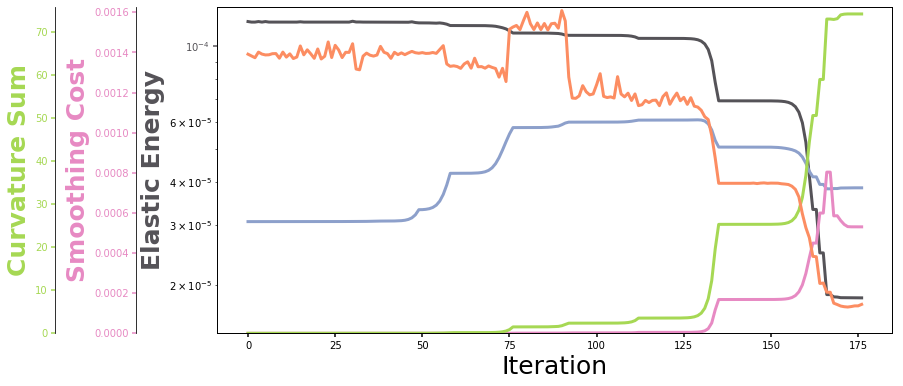

In [73]:
figure_label_size = 25
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()
par4 = host.twinx()


par2.spines["left"].set_position(("axes", -0.12))

make_patch_spines_invisible(par2)

par2.spines["left"].set_visible(True)
par2.yaxis.set_label_position('left')
par2.yaxis.set_ticks_position('left')

par3.spines["left"].set_position(("axes", -0.24))

make_patch_spines_invisible(par3)

par3.spines["left"].set_visible(True)
par3.yaxis.set_label_position('left')
par3.yaxis.set_ticks_position('left')


p5, = par4.plot(range(len(dps_smoothing)), dps_distance_to_surface, linewidth = 3, color = target_color, label=target_label)

p1, = host.plot(range(len(dps_smoothing)), dps_energy, linewidth = 3, color = elastic_color, label=elastic_label)
p2, = par1.plot(range(len(dps_smoothing)), dps_rest_length, linewidth = 3, color = rest_length_color, label=rest_length_label)
p3, = par2.plot(range(len(dps_smoothing)), dps_smoothing, linewidth = 3, color = smoothness_color, label=smoothness_label)
p4, = par3.plot(range(len(dps_total_absolute_curvature)), dps_total_absolute_curvature, linewidth = 3, color = curvature_color, label=curvature_label, linestyle = '-')

set_figure_label_and_limit(host, par1, par2, par3, par4, p1, p2, p3, p4, p5)

lines = [p1, p2, p3, p4, p5]

par1.yaxis.set_visible(False)
par2.yaxis.set_visible(True)
par3.yaxis.set_visible(True)
par4.yaxis.set_visible(False)

fig.set_size_inches(figure_size)
fig.savefig('kleinbottle_nature_figure3_D_bottom_left.png', bbox_inches='tight', dpi=400)
plt.show()

### Figure 3E Bottom Right

<ipython-input-79-5bcdb08d12f4>:57: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(host.transAxes)


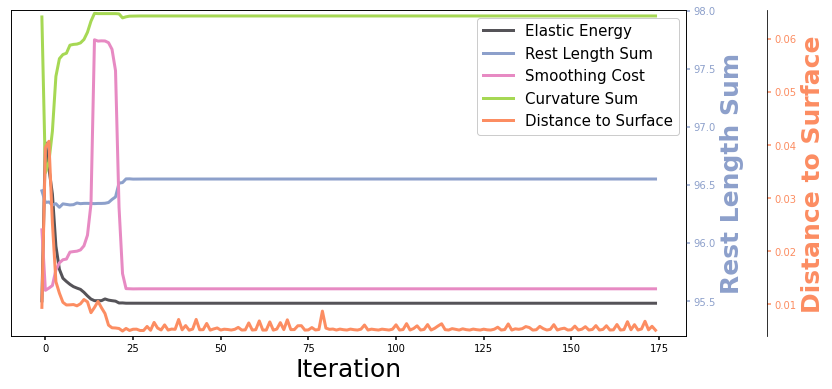

In [79]:
figure_label_size = 25
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()
par4 = host.twinx()
# par5 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.12))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(False)


par3.spines["right"].set_position(("axes", 1.24))
make_patch_spines_invisible(par3)
par3.spines["right"].set_visible(False)

par4.spines["right"].set_position(("axes", 1.12))
make_patch_spines_invisible(par4)
par4.spines["right"].set_visible(True)


x_range = [-1] + [x for x in range(len(opt_distance_to_surface))]
p5, = par4.plot(x_range, [dps_distance_to_surface[-1]] + list(opt_distance_to_surface), linewidth = 3, color = target_color, label=target_label)

p1, = host.plot(x_range, [dps_elastic_energy[-1]] + list(opt_elastic_energy), linewidth = 3, color = elastic_color, label=elastic_label)
p2, = par1.plot(x_range, [dps_rest_length[-1]] + list(opt_rest_length), linewidth = 3, color = rest_length_color, label=rest_length_label)
p3, = par2.plot(x_range, [dps_smoothing[-1]] + list(opt_smoothing), linewidth = 3, color = smoothness_color, label=smoothness_label)
p4, = par3.plot(x_range, [dps_total_absolute_curvature[-1]] + list(opt_total_absolute_curvature), linewidth = 3, color = curvature_color, label=curvature_label, linestyle = '-')

set_figure_label_and_limit(host, par1, par2, par3, par4, p1, p2, p3, p4, p5)

lines = [p1, p2, p3, p4, p5]

host.yaxis.set_visible(False)
par1.yaxis.set_visible(True)
par2.yaxis.set_visible(False)
par3.yaxis.set_visible(False)
par4.yaxis.set_visible(True)
# plt.axvline(x=opt_iteration_count, color=cmap(8), linestyle='--')
leg = host.legend(lines, [l.get_label() for l in lines], loc="upper right", facecolor='white', framealpha=1, fancybox=True, prop={'size': 15})

bb = leg.get_bbox_to_anchor().inverse_transformed(host.transAxes)

# Change to location of the legend. 
yOffset = -0.2
bb.y0 += yOffset
leg.set_bbox_to_anchor(bb, transform = host.transAxes)

fig.set_size_inches(figure_size)
fig.savefig('kleinbottle_nature_figure3_D_bottom_right.png', bbox_inches='tight', dpi=400)
plt.show()